

1.   Read Patient Wise InferCNV profile
2.   Cluster the patient info based on hierarchical agglomerative  clustering using ward linkage.
3.   Generate the average of each cluster - resulting in the signal  corresponding to the cluster
4.   Generating significant A-B signal using low pass filter - obtained using monte carlo randomization.
5.  for each combination of clusters-
    get A-B ; and see if they are related  


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# %config InlineBackend.figure_format='retina'
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='darkgrid')
import numpy as np
import numpy.random as rnd
import statistics
import math
import itertools
import random


In [ ]:
## for minimum spanning tree 
# Python program for Kruskal's algorithm to find
# Minimum Spanning Tree of a given connected,
# undirected and weighted graph

from collections import defaultdict

# Class to represent a graph


class Graph:

	def __init__(self, vertices):
		self.V = vertices # No. of vertices
		self.graph = [] # default dictionary to store graph 

	# function to add an edge to graph
	def addEdge(self, u, v, w):
		self.graph.append([u, v, w])

	# A utility function to find set of an element i
	# (uses path compression technique)
	def find(self, parent, i):
		if parent[i] == i:
			return i
		return self.find(parent, parent[i])

	# A function that does union of two sets of x and y
	# (uses union by rank)
	def union(self, parent, rank, x, y):
		xroot = self.find(parent, x)
		yroot = self.find(parent, y)
		# Attach smaller rank tree under root of
		# high rank tree (Union by Rank)

		if rank[xroot] < rank[yroot]:
			parent[xroot] = yroot
		elif rank[xroot] > rank[yroot]:
			parent[yroot] = xroot

		# If ranks are same, then make one as root
		# and increment its rank by one
		else:
			parent[yroot] = xroot
			rank[xroot] += 1

	##MST using kruskal algorithm
	def KruskalMST(self):

		result = [] # This will store the resultant MST
		
		# An index variable, used for sorted edges
		i = 0
		# An index variable, used for result[]
		e = 0
		self.graph = sorted(self.graph,
							key=lambda item: item[2])
		parent = []
		rank = []

		# Create V subsets with single elements
		for node in range(self.V):
			parent.append(node)
			rank.append(0)

		# Number of edges to be taken is equal to V-1
		while e < self.V - 1:
			u, v, w = self.graph[i]
			i = i + 1
			x = self.find(parent, u)
			y = self.find(parent, v)

			if x != y:
				e = e + 1
				result.append([u, v, w])
				self.union(parent, rank, x, y)

		minimumCost = 0
		print ("Edges in the constructed MST")
		for u, v, weight in result:
			minimumCost += weight
			print("%d -- %d == %d" % (u, v, weight))
		print("Minimum Spanning Tree" , minimumCost)



In [ ]:
def get_patient_df(patient_path):
  """
  read patient_wise infercnv profile
  """
  df=pd.read_csv(os.path.join(patient_path,"infercnv.observations.txt"),sep=" ")
  return df

def get_PCA_component(patient_df):
    """
    plotting the scatter plot using PCA as dimension reduction
    """
    X=patient_df
    pca = PCA(n_components=20)
    principalComponents = pca.fit_transform(X)

    # Plot the explained variances ;scree plot
    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_ratio_, color='black')
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(features)
    plt.title("SCREE Plot")
    plt.show()
    # Save components to a DataFrame
    PCA_components = pd.DataFrame(principalComponents)
    plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='blue')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()
    
    X['PCA_1']=PCA_components[0].tolist()
    X['PCA_2']=PCA_components[1].tolist()

    return X

def plot_dendogram_HAC(patient_df):
    """
    Plotting dendogram for visualizing hierarchy
    """

    X=patient_df.copy()
    plt.figure(figsize=(20, 20))

    # Plot the hierarchical clustering as a dendrogram.
    temp = hierarchy.linkage(X, 'ward')
    plt.figure()

    dn = hierarchy.dendrogram(
      temp, above_threshold_color="green", color_threshold=.7)

    plt.show()

def get_clusters(patient_df,n):
    """
    Clustering the patient wise infercnv profile
    """
    X=patient_df
    cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    cluster_labels=cluster.fit_predict(X)
    X['cluster_labels']=cluster_labels
    unique_label=np.unique(cluster_labels)
    for i in unique_label:
      plt.scatter(X[X['cluster_labels']==i]['PCA_1'],X[X['cluster_labels']==i]['PCA_2'],label=i)
    plt.legend()
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    ### edit this according to the patient
    plt.title("Scatter plot for BCH836")

    plt.show()
    return X

def get_avg_cluster_expr(patient_df):
  """
  Average expression per cluster
  """
  X=patient_df.copy()
  X_grouped=X.groupby(['cluster_labels'])
  each_cluster=[]
  for key,item in X_grouped:
    each_cluster.append(X_grouped.get_group(key))

  for cluster in each_cluster:
      cluster.drop(columns=['cluster_labels','PCA_1','PCA_2'],inplace=True)

  ##average_expression
  average_expression={}
  for i,cluster in enumerate(each_cluster):
      average_expression['cluster_'+str(i)]=cluster.mean()
  return average_expression

def plot_avg_cluster_expr(average_expression):
  colors=['red','orange','black','blue','green','purple','yellow']
  for key in average_expression:
    print(key)
  for cluster_ in average_expression:
      df=pd.DataFrame()
      X=[i for i in range(len((average_expression[cluster_])))]
      Y=list(average_expression[cluster_])
      df['genes']=X
      df['average expression']=Y
      index=int(cluster_.split("_")[1])
      sns.relplot(data=df,x='genes',y='average expression',kind='scatter',color=colors[index],size=0.1)
      
def get_expression(df,index):
   X=df.copy()
   X.drop(columns=['cluster_labels','PCA_1','PCA_2'],inplace=True)
   return X.loc[index]

def get_random_index(seed,index_list):
    return random.choice(index_list)
    
def get_sample_A_B(patient_df,seed,samples):
    """
    samples of A-B
    """
    X=patient_df.copy()
    clusters=list(set(X['cluster_labels'].tolist()))
    combination_clusters=list(itertools.combinations(clusters, 2))
    final_vector=[]

    for each in  combination_clusters:
      while samples:
        index_A=X[X['cluster_labels']==each[0]].index
        A = list(get_expression(X,get_random_index(seed,index_A)))
        index_B=X[X['cluster_labels']==each[1]].index
        B = list(get_expression(X,get_random_index(seed+1,index_B)))
        final_vector.append(np.subtract(A,B))
        samples-=1
        

    return np.array(final_vector).flatten()


def get_significant_signal(patient_df,samples):
      """
      significant signal using monte carlo randomization
      """
      distribution=get_sample_A_B(patient_df,2,samples)
      plt.hist(distribution)
      mean_=sum(distribution)/len(distribution)
      std_=statistics.stdev(distribution)
      confidence_interval=[]
      confidence_interval.append(mean_-1.96*std_)
      confidence_interval.append(mean_+1.96*std_)

      print(confidence_interval)
      plt.axvline(x =mean_, color = 'r', label = 'axvline - full height')
      plt.axvline(x =confidence_interval[0], color = 'r', label = 'axvline - full height')
      plt.axvline(x =confidence_interval[1], color = 'r', label = 'axvline - full height')
      plt.xlabel('A-B')
      plt.ylabel('frequency')
    ### edit this according to the patient
      plt.show()

      sns.distplot(distribution,hist=True,kde=True,color='darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth':4})
      plt.show()

      return confidence_interval


def low_pass_filter(lst,range):
  """
  filtering the expression signal
  """
  for index,value in enumerate(lst):
    if value>=range[0] and value<=range[1]:
       lst[index]=0
  return lst

def df_utils(colx,coly,X,Y):
    df=pd.DataFrame()
    df[colx]=X
    df[coly]=Y
    return df

def signal_plot(signal,color):
    """
    plot signal
    """
    X=[i for i in range(len(signal))]
    df=df_utils('gene','avg_expression',X,signal)
    sns.relplot(data=df,x='gene',y='avg_expression',kind='scatter',color=color)
    plt.show()



def get_spike_info(vctr):
  '''
  count of spikes , sum of spike value , position of spikes occurence
  '''
  sum_spike=[]
  pos_spike=[]
  count=0
  l=0
  r=-1
  each_sum=0
  each_pos=[]
  index=0
  
  if vctr[index]!=0: #doesn't start with 0
    count+=1
    each_pos.append(l)
    while l<len(vctr) and vctr[l]!=0:
         each_sum+=vctr[l]
         l+=1
         index=l
         
  if each_sum!=0:
    each_pos.append(l)
    sum_spike.append(each_sum)
    pos_spike.append(each_pos)
    each_pos=[]
    each_sum=0

  while index<len(vctr):
     l=index
     while l<len(vctr) and vctr[l]==0:
         l+=1
         index=l
         r=l+1

     if r!=-1 and r<len(vctr):
       each_sum+=vctr[l]
       each_pos.append(l)
       while r<len(vctr) and vctr[r]!=0 :
          index=r
          each_sum+=vctr[r]
          r+=1

     if r-1-l >1 and each_sum!=0:
       count+=1
       sum_spike.append(each_sum)
       each_pos.append(r-1)
       pos_spike.append(each_pos)
       each_pos=[]
       l=r
       r=-1
       each_sum=0
    
     index+=1
 
  return count,sum_spike,pos_spike    


def plot_heatmap(patient_df,cluster_label):

  data=patient_df[patient_df['cluster_labels']==cluster_label].copy()
  data.drop(columns=['cluster_labels'],inplace=True)
  hm = sns.heatmap(data = data.to_numpy())
# displaying the plotted heatmap
  plt.show()

def shift_mean(original_mean,lst):
  '''
  shifting mean to 0
  '''
  lst=[ x-original_mean for x in lst]
  return lst

def get_spike_dirn(sum_spike):
  dirn= -1 if sum_spike<0 else 1
  return dirn

def get_relation(A,B,AminusB,BminusA):
  """
  The cases of the signal observed
  """
  case=-1 
  ## if valid_diff=0 ; A-B ok ; if valid_diff=1  ; B-A ok ;-1 means neither A-B nor B-A ok ; valid_diff=2 identical
  valid_diff=-1
  loop_cnt=0

  for id,diff_signal in enumerate([AminusB,BminusA]):
    count_spike,sum_spike_child,pos_spike=get_spike_info(diff_signal)

    ##
  
    if count_spike==0:
        valid_diff=2
        return id,valid_diff
    ##
    lst=[A,B]
    for id,parent in enumerate(lst):
      count=count_spike
      while count>0:
          index=count-1
          dirn_child=get_spike_dirn(sum_spike_child[index])
          parent_spike=parent[pos_spike[index][0]:pos_spike[index][1]]
          dirn_parent=get_spike_dirn(sum(parent_spike))

          magnitude_spike_child=abs(sum_spike_child[index])
          magnitude_spike_parent=abs(sum(parent_spike))


          if dirn_child!=dirn_parent or  magnitude_spike_parent<magnitude_spike_child:
             break

          loop_cnt+=1
          count-=1
          
      if loop_cnt==count_spike:
        valid_diff=id
        break

  return id,valid_diff


def is_transitive(relation):
    transitive_reln=[]
    for a,b in relation:
        for c,d in relation:
            if b == c and ([a,d]  in relation):
               transitive_reln.append([a,d])
    return transitive_reln 

def non_transitive(relation,transitive_relation):
    non_transitive=[]
    for [a,b] in relation :
      if [a,b] not in transitive_relation:
        non_transitive.append([a,b]) 
    return non_transitive

def constr_clonal_phylo(average_expression,confidence_interval,patient_df):
  """
  method to construct clonal phylogeny
  """
  edges=[]
  clusters=[key for key in average_expression]
  print(clusters)
  combination_clusters=list(itertools.combinations(clusters, 2))
  for each in combination_clusters:
    A=list(average_expression[each[0]])
    B=list(average_expression[each[1]])
    AminusB=np.subtract(A,B)
    AminusB=low_pass_filter(AminusB,confidence_interval)
    

    BminusA=np.subtract(B,A)
    BminusA=low_pass_filter(BminusA,confidence_interval)
    
    ## centering the mean from 1 to 0 ; mean 1 is observed through the distribution
    print("A after mean centering")
    A=shift_mean(1, A)
    signal_plot(A,"black")

    print("B after mean centering")
    B=shift_mean(1,B)
    signal_plot(B,"red")
    

    print("A-B")
    signal_plot(AminusB,"black")

    print("B-A")
    signal_plot(BminusA,"red")

    case,valid_diff=get_relation(A,B,AminusB,BminusA)
    print("output_reln",case,valid_diff)
    cluster_labelA=int(each[0].split("_")[1])
    cluster_labelB=int(each[1].split("_")[1])

    node_A=int(each[0].split("_")[1])
    node_B=int(each[1].split("_")[1])

    if valid_diff==-1:
      print("no reln")
    elif valid_diff==0:
      print("B->A")
      edges.append([node_B,node_A] )    
    elif valid_diff==1:
      print("A->B")
      edges.append([node_A,node_B])
    elif valid_diff==2:
      print("A identical to B")

    non_transitive_reln=non_transitive(edges,is_transitive(edges))
    print(non_transitive_reln)
    print("cluster A heatmap:")
    plot_heatmap(patient_df,cluster_labelA)

    print("cluster B heatmap:")
    plot_heatmap(patient_df,cluster_labelB)
    
  g = Graph(len(clusters)+1) ## +1 for one root node
  root_node=len(clusters) ##one root node 
  for [a,b] in non_transitive_reln:
       g.addEdge(a, b, 1)
  end_node=[b for a,b in non_transitive_reln ]
  non_root_nodes=[i for i in range(3)] 

  ## adding edge root->end_node
  for node in non_root_nodes:
    if node not in end_node:
      g.addEdge(root_node, node, 1)
  
  print("root_node",root_node)   
  g.KruskalMST()




In [ ]:
def plot_avg_cluster_expr(average_expression):
  colors=['red','orange','black','blue','green','purple','yellow']
  for key in average_expression:
    print(key)
  for cluster_ in average_expression:
      df=pd.DataFrame()
      X=[i for i in range(len((average_expression[cluster_])))]
      Y=list(average_expression[cluster_])
      df['genes']=X
      df['average expression']=Y
      index=int(cluster_.split("_")[1])
      # sns.relplot(data=df,x='genes',y='average expression',kind='scatter',color=colors[index],size=0.1)
      Y=shift_mean(1,Y)
      signal_plot(signal,colors[index])

[-0.11927085264436692, 0.10939332504202225]


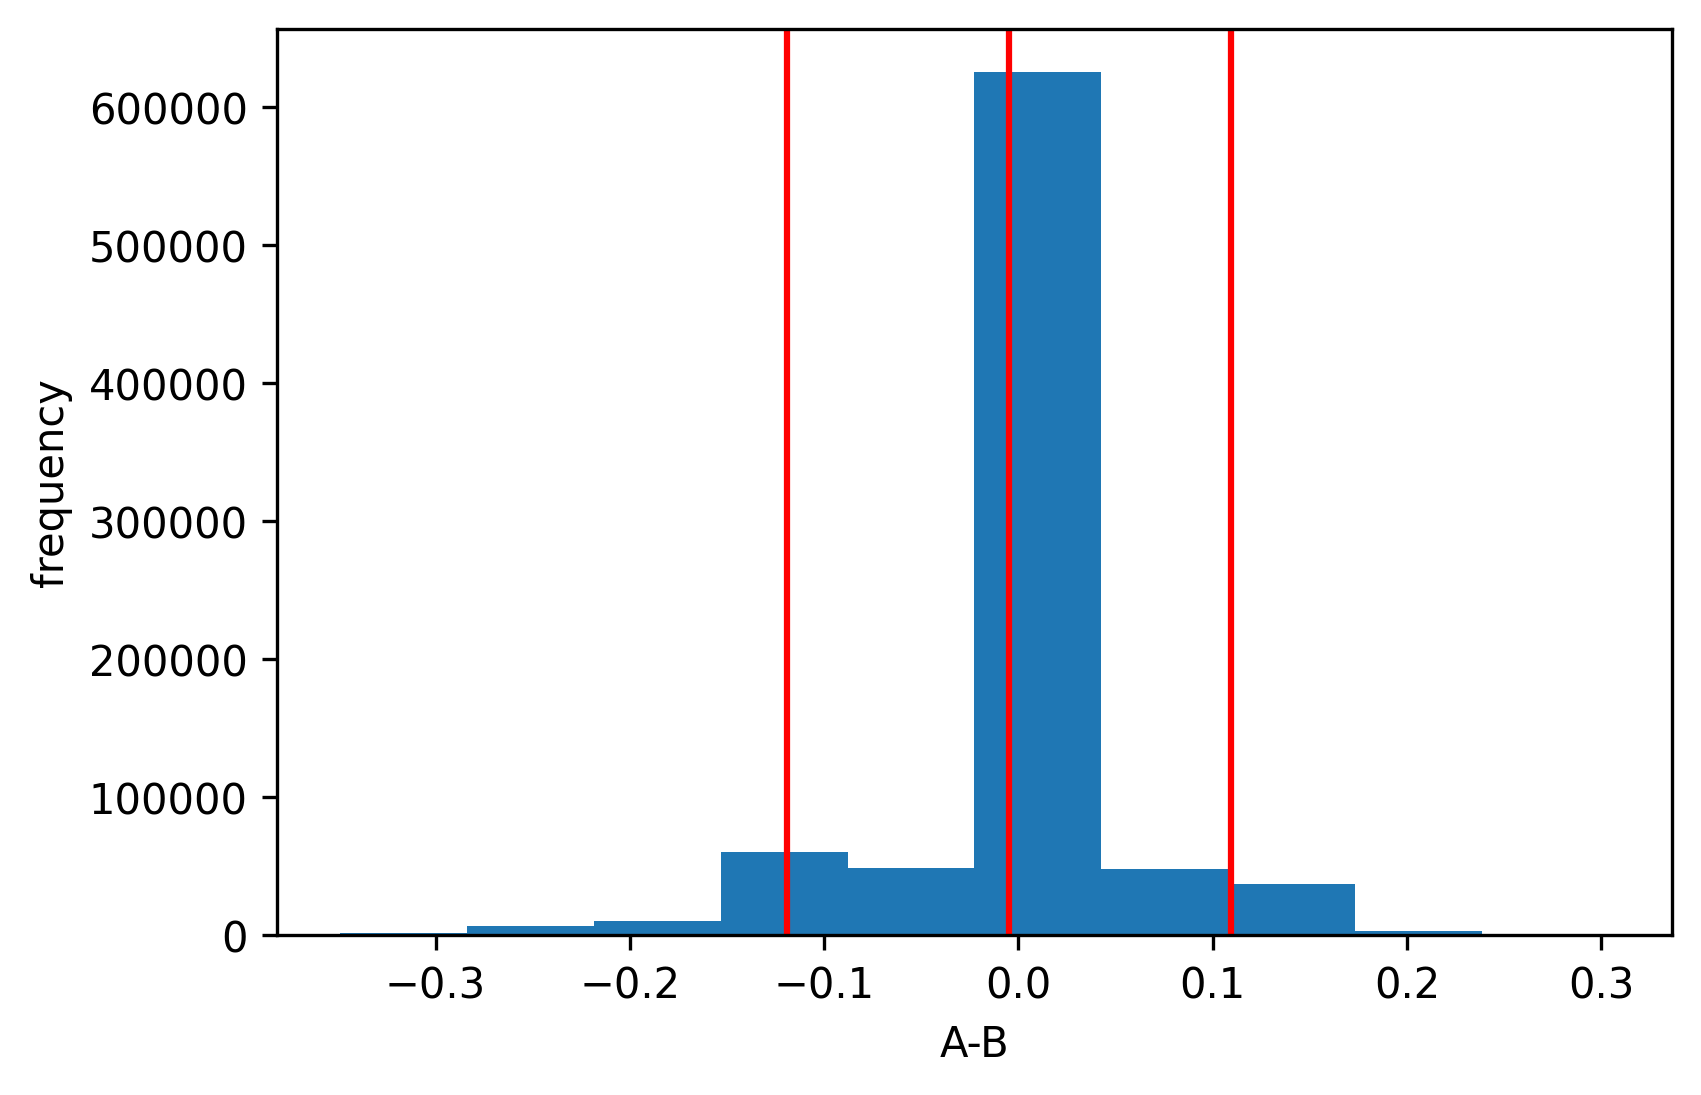

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


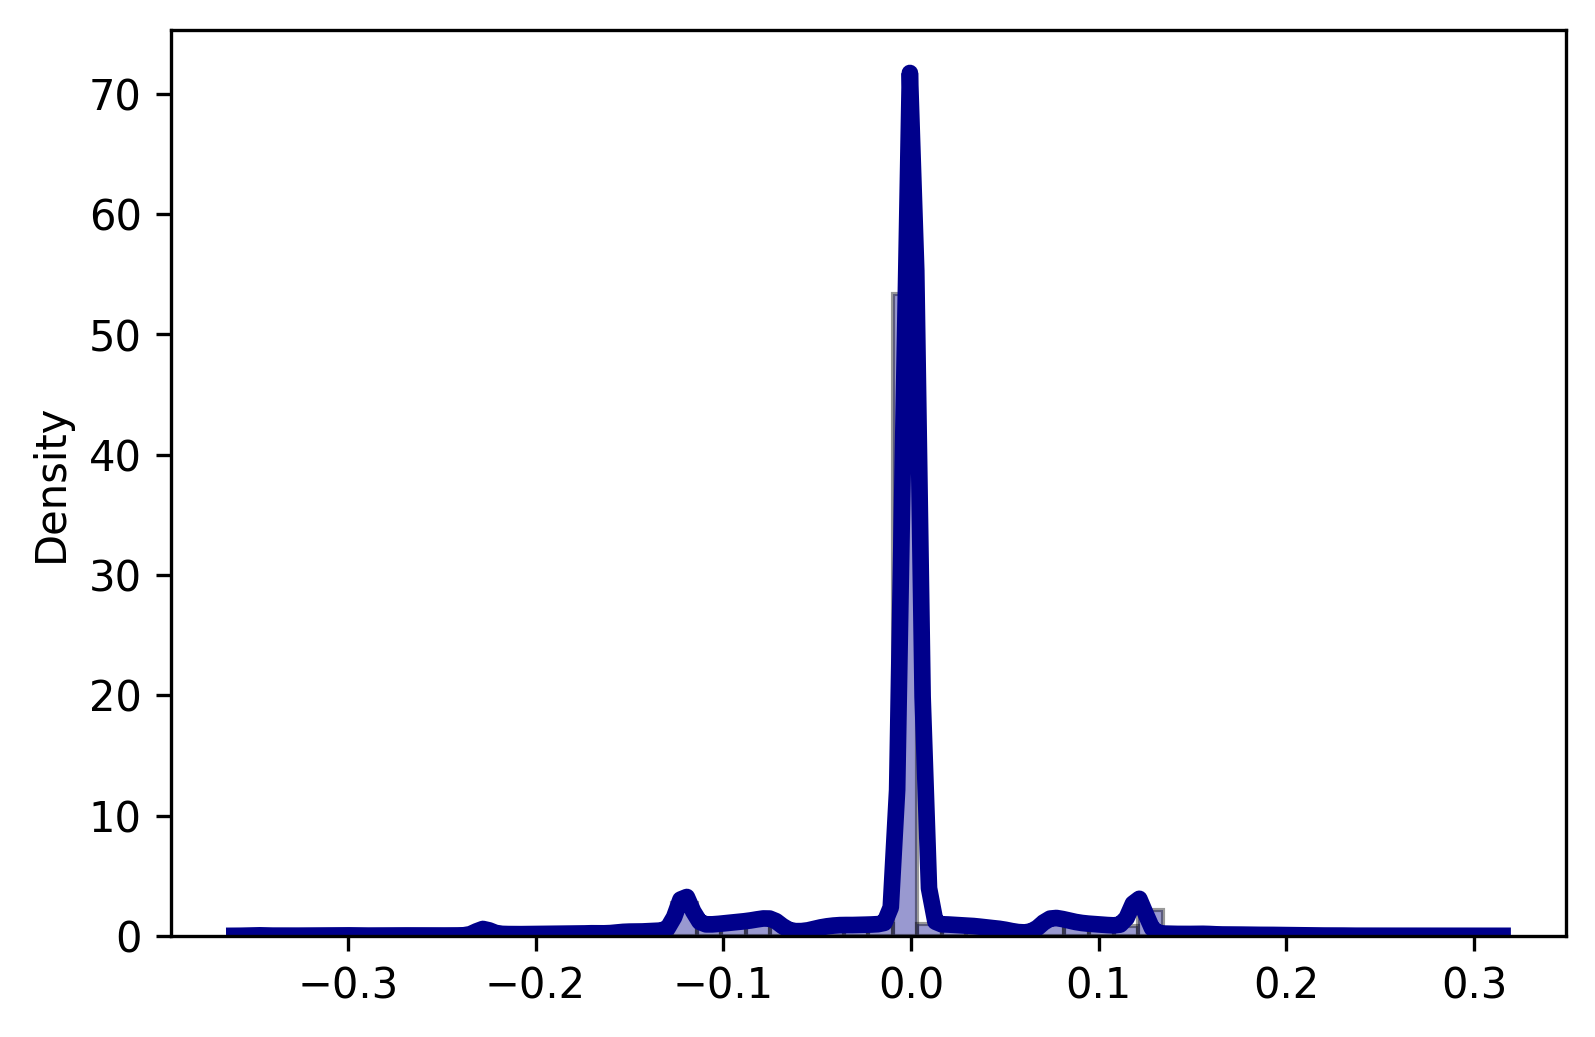

In [ ]:
# patient_path="/content/drive/MyDrive/Project_IP&Thesis/Kiran_Thesis/Project_Clonal/BCH836_output_dir"
# patient_df=get_patient_df(patient_path)
# #   #######################
# plot_dendogram_HAC(patient_df)
# patient_df=get_PCA_component(patient_df)
# patient_df=get_clusters(patient_df,3)
# # #   ###########################
# average_expression=get_avg_cluster_expr(patient_df)
# plot_avg_cluster_expr(average_expression)
# #   ##################
confidence_interval=get_significant_signal(patient_df,100)
# # # #   ################


['cluster_0', 'cluster_1', 'cluster_2']
A after mean centering


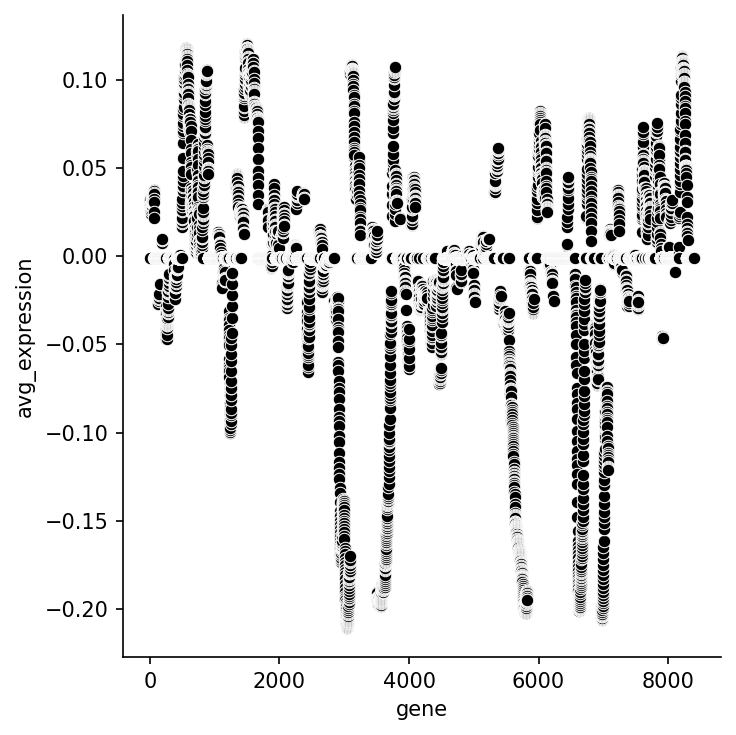

B after mean centering


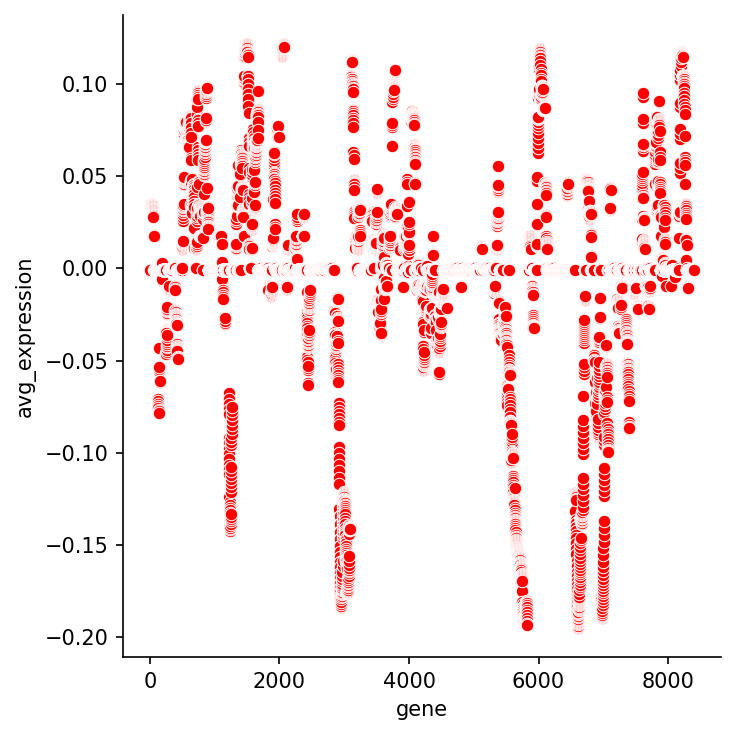

A-B


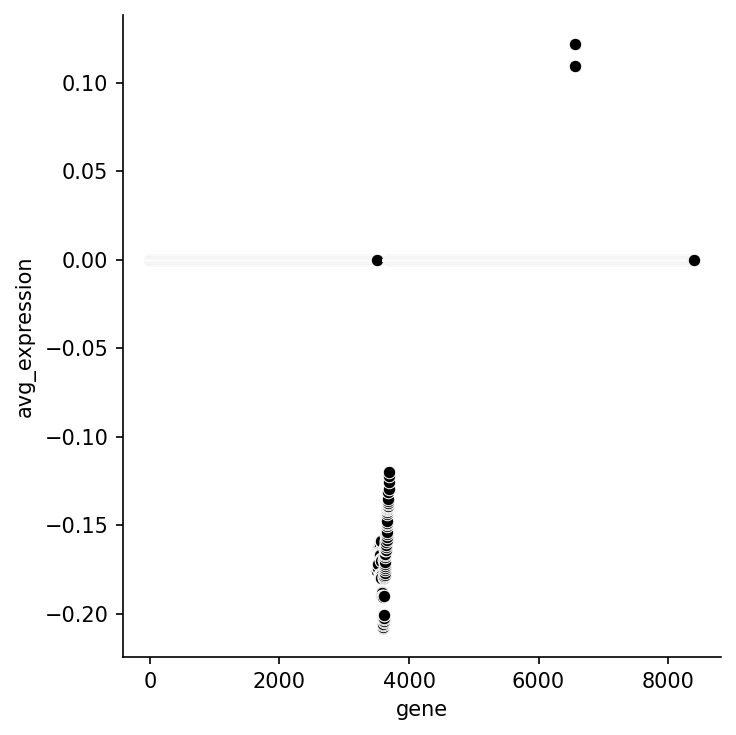

B-A


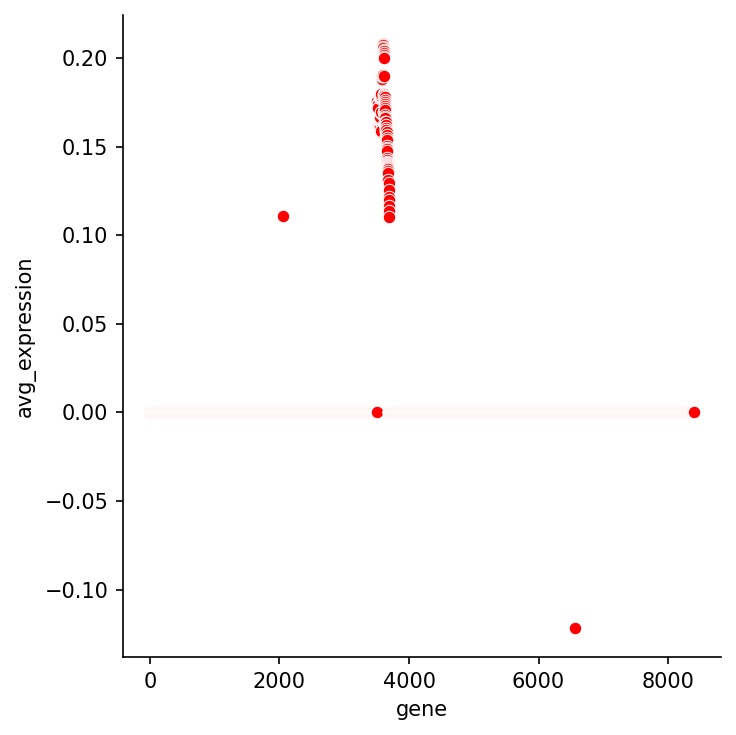

output_reln 0 0
B->A
[[1, 0]]
cluster A heatmap:


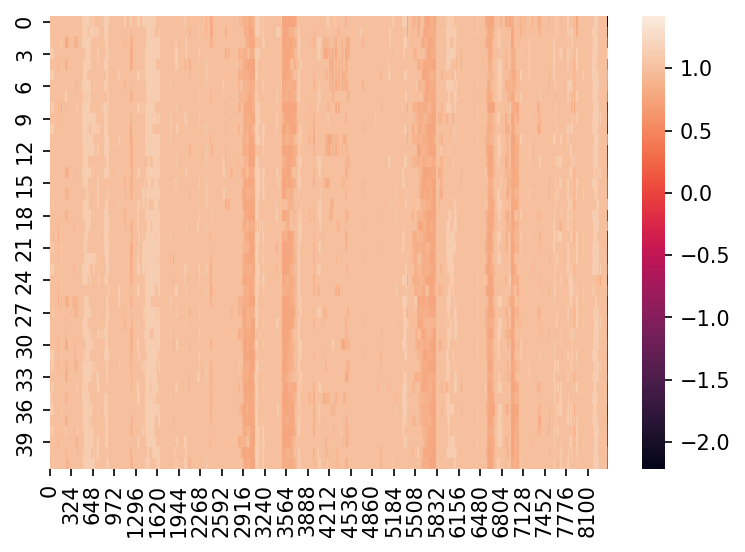

cluster B heatmap:


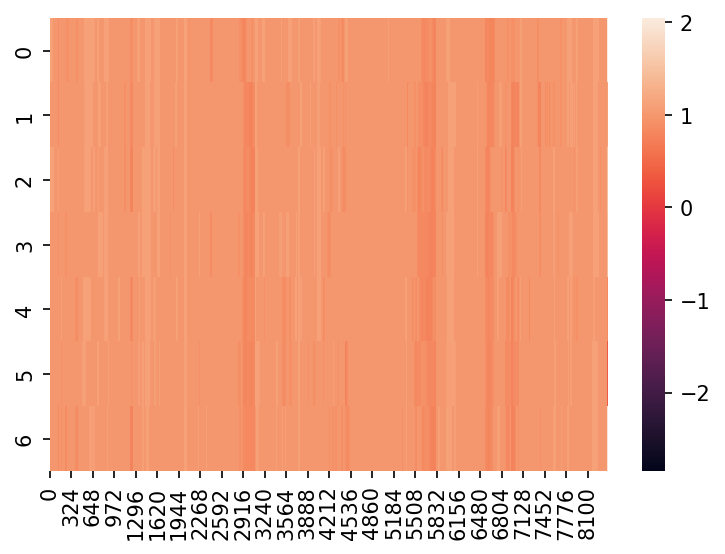

A after mean centering


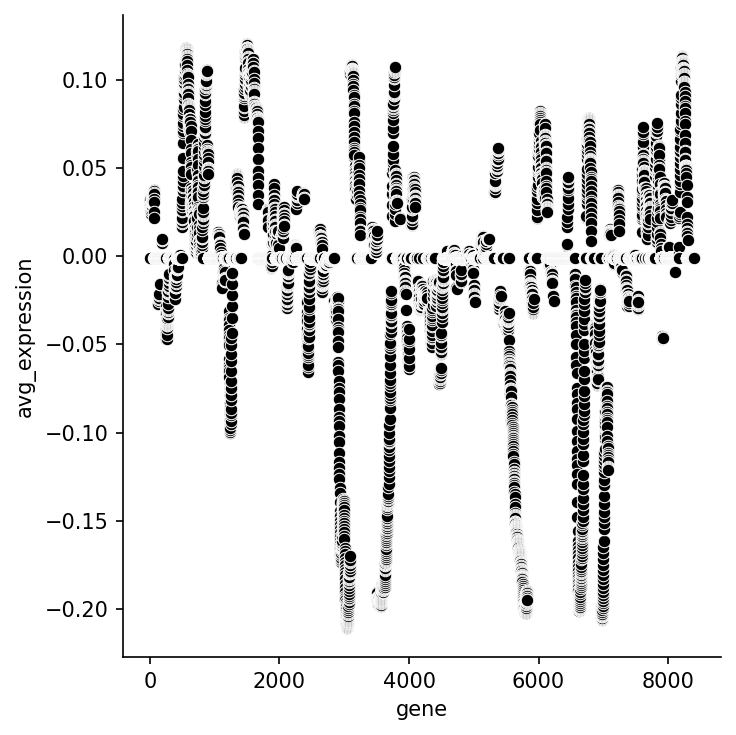

B after mean centering


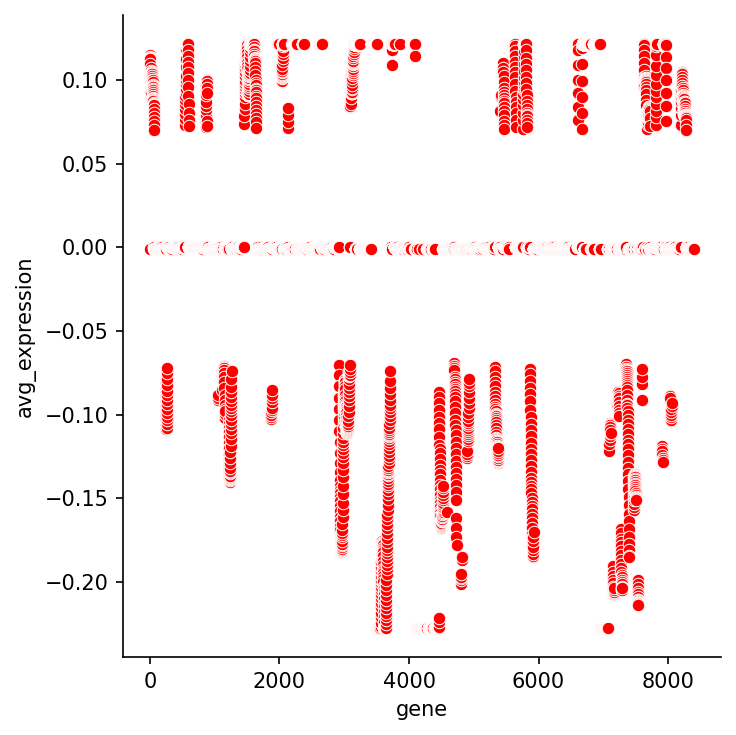

A-B


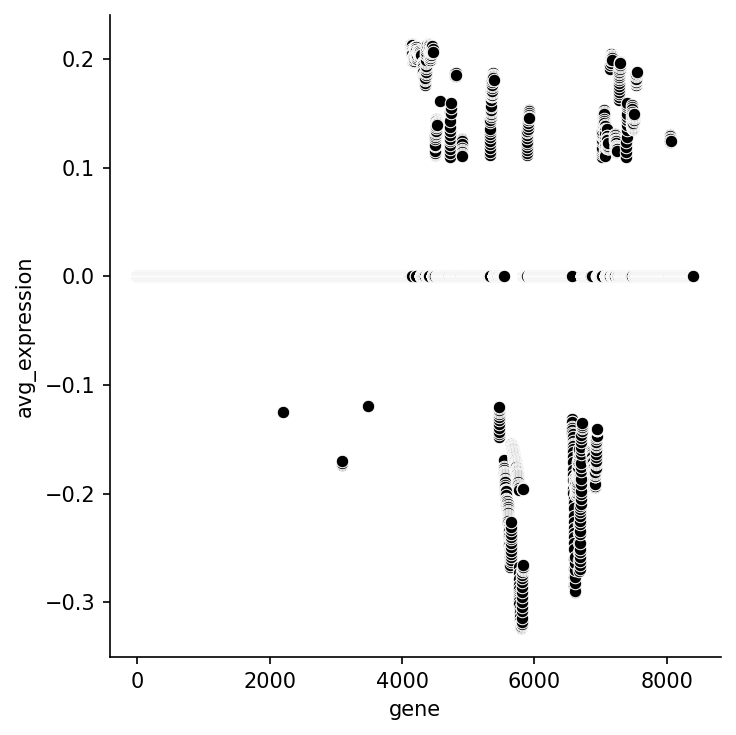

B-A


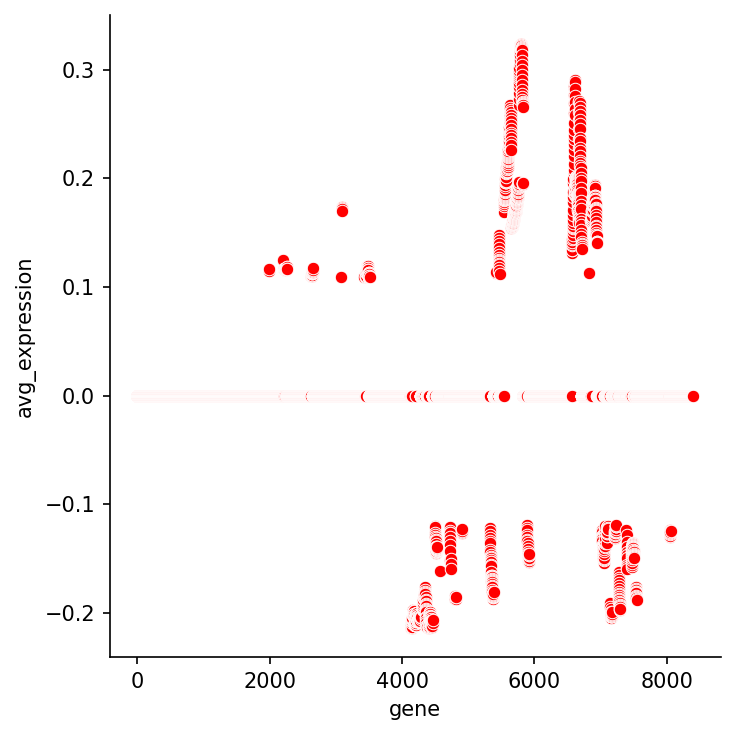

output_reln 1 -1
no reln
[[1, 0]]
cluster A heatmap:


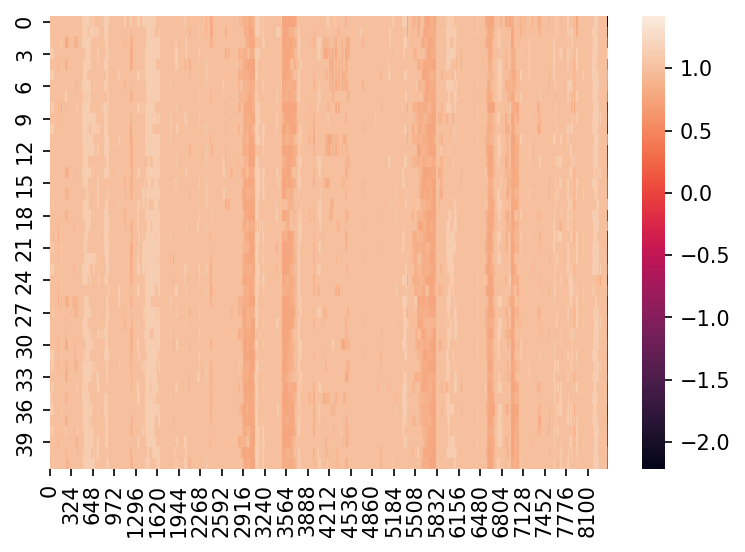

cluster B heatmap:


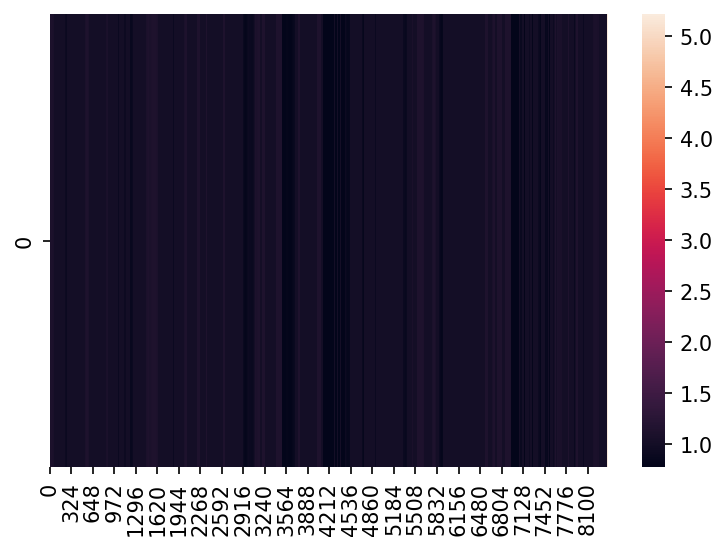

A after mean centering


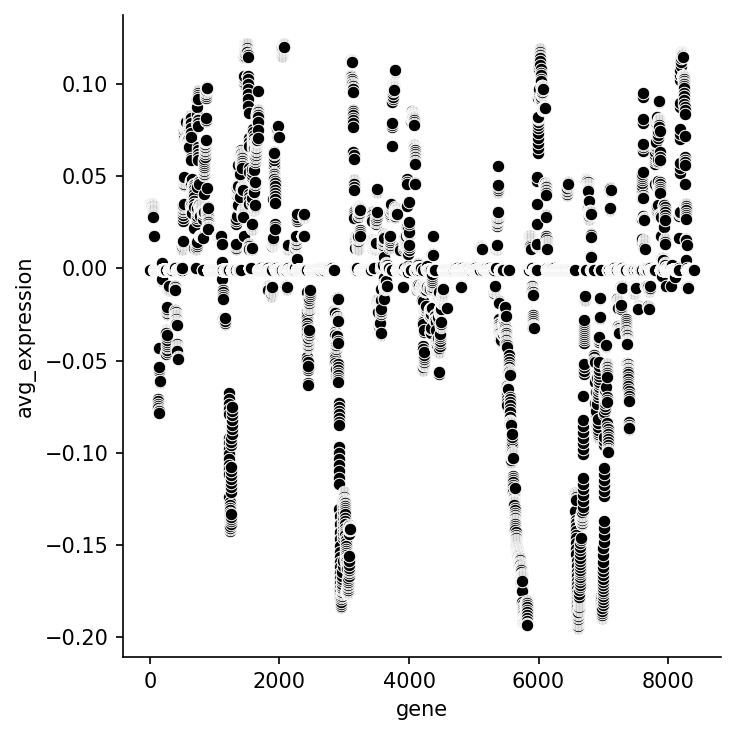

B after mean centering


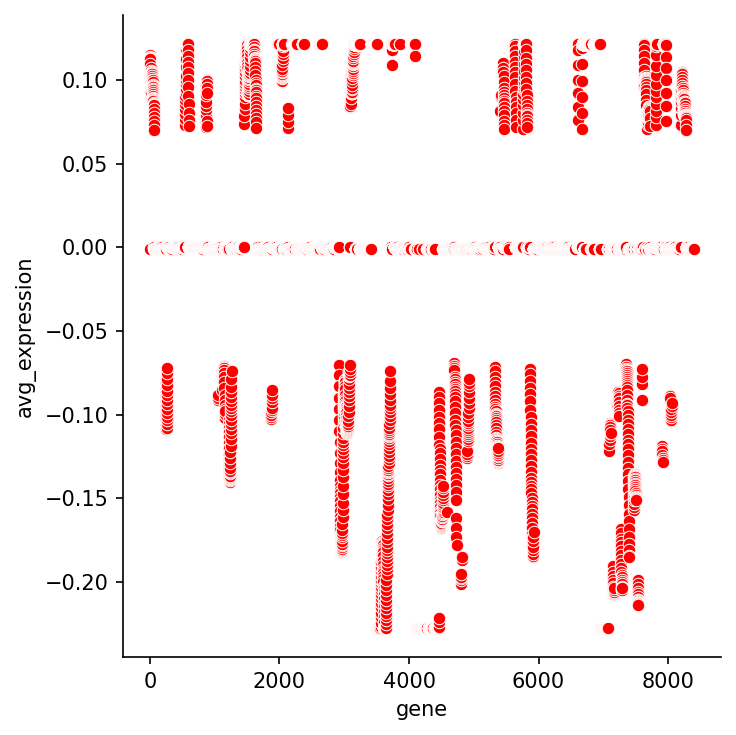

A-B


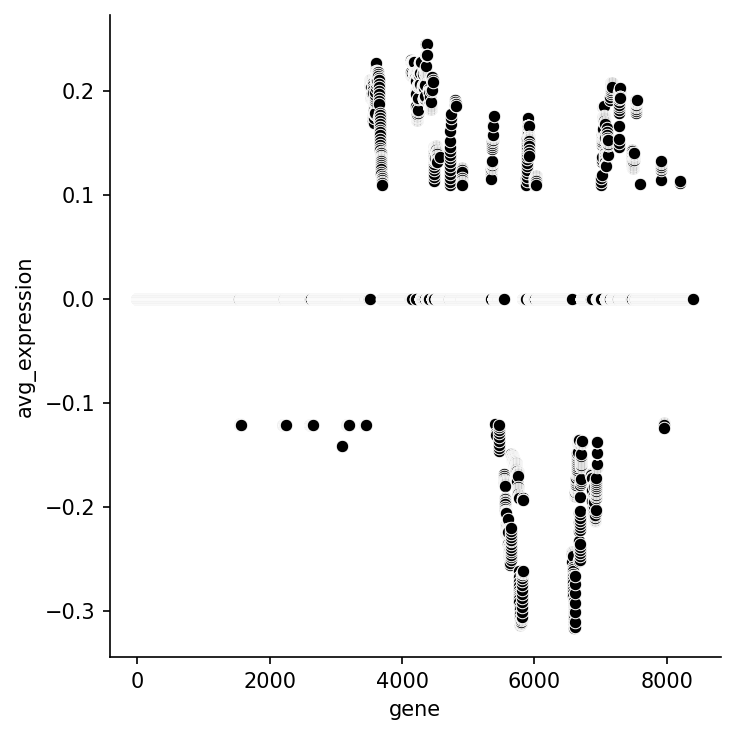

B-A


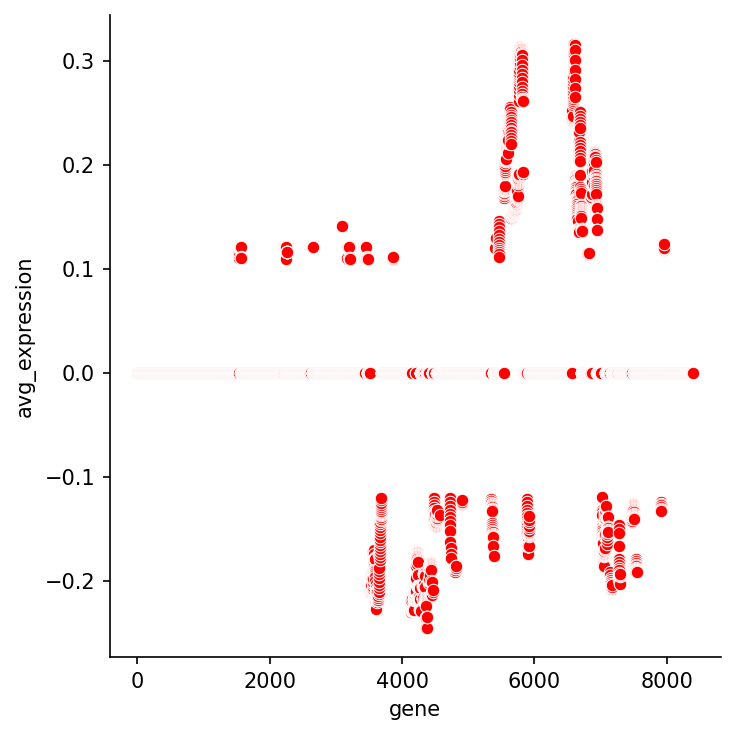

output_reln 1 -1
no reln
[[1, 0]]
cluster A heatmap:


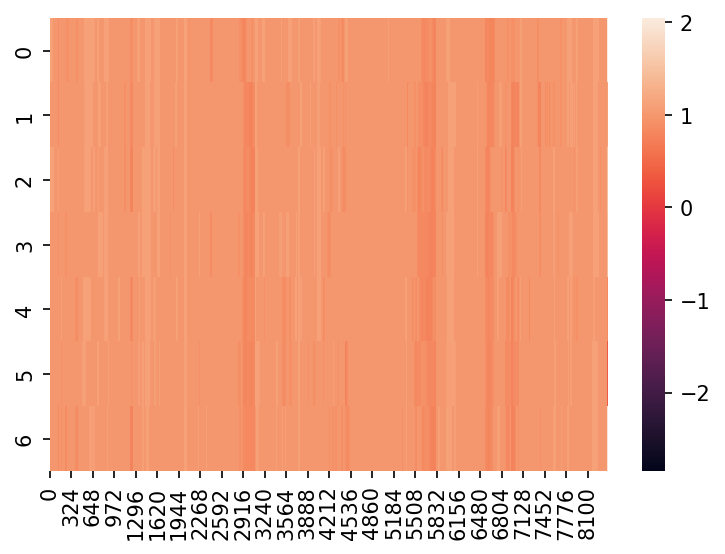

cluster B heatmap:


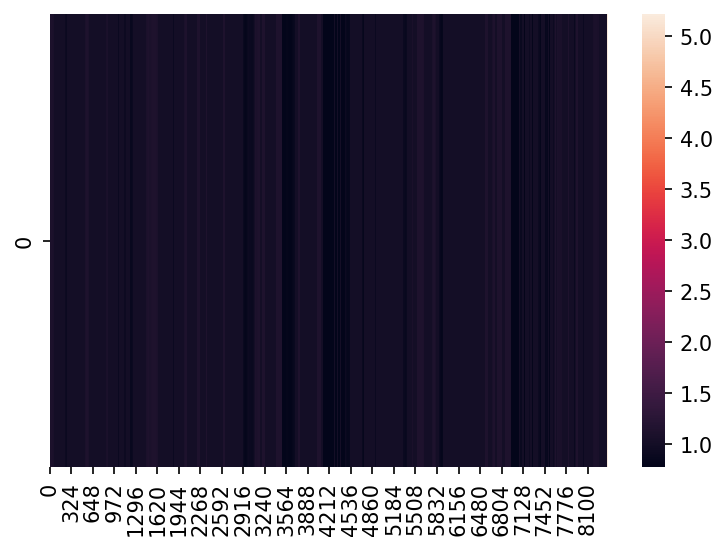

root_node 3
Edges in the constructed MST
1 -- 0 == 1
3 -- 1 == 1
3 -- 2 == 1
Minimum Spanning Tree 3


In [ ]:
constr_clonal_phylo(average_expression,confidence_interval,patient_df)

In [ ]:
def main_function(patient_path):
  patient_df=get_patient_df(patient_path)
  #######################
  # plot_dendogram_HAC(patient_df)
  patient_df=get_PCA_component(patient_df)
  patient_df=get_clusters(patient_df,3)
  ###########################
  average_expression=get_avg_cluster_expr(patient_df)
  ##################
  confidence_interval=get_significant_signal(patient_df,100)
  #################
  constr_clonal_phylo(average_expression,confidence_interval,patient_df)